## EDA - 데이터 기초 통계 및 이상치 확인, 제거
### 1. 데이터 통계 확인
- PostgreSQL server로부터 3시간치 데이터 불러오기
- 데이터의 개수, 평균, 표준편차, 최소값, 최대값 등의 통계 확인
- 데이터의 앞부분 5개와 뒷부분 5개 출력

### 2. 데이터 이상치 확인
- sog, cog, heading, latitude, longitude 의 이상치 확인
- seaborn의 box plot을 활용

### 3. 데이터 이상치 제거 및 제거 확인
- IQR 방법을 활용해 데이터의 이상치 제거
- seaborn의 box plot을 다시 그려 이상치가 잘 제거됐는지 확인

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import psycopg2
from sqlalchemy import create_engine
from geopy.distance import geodesic

In [2]:
# Seaborn 스타일 설정
sns.set_theme(style="whitegrid")

# ✅ PostgreSQL 연결 정보
DB_HOST = "localhost"   # DB ip 주소로 변경해야 함
DB_PORT = "5432"
DB_NAME = "ais_data"
DB_USER = "postgres"
DB_PASS = "ky76018500"

In [3]:
# ✅ 특정 시간 기준 3시간치 데이터 가져오기
# 분석할 기준 시간 설정
start_time = "2020-02-13 00:00:00" 
end_time = "2020-02-13 03:00:00"
query = f"""
SELECT mmsi, timestamp, latitude, longitude, sog, cog, heading 
FROM ais
WHERE timestamp BETWEEN '{start_time}' AND '{end_time}';
"""
engine = create_engine(f"postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}")
df = pd.read_sql(query, engine)

In [4]:
# ✅ 컬럼명 변환
df.rename(columns={"timestamp": "datetime"}, inplace=True)

# ✅ 데이터 타입 변환
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.astype({
    "mmsi": "string",
    "latitude": "float32", "longitude": "float32",
    "sog": "float32", "cog": "float32", "heading": "float32"
})

In [16]:
# ✅ 기본 통계 분석
descriptive_stats = df[["sog", "cog", "heading", "latitude", "longitude"]].describe()
descriptive_stats.loc["range"] = descriptive_stats.loc["max"] - descriptive_stats.loc["min"]
print("Basic Statistics:\n", descriptive_stats)
print("\nData head(5): \n", df.head(5))
print("\nData tail(5): \n", df.tail(5))

Basic Statistics:
                 sog           cog       heading      latitude     longitude
count  2.152324e+06  2.152324e+06  2.152324e+06  2.152324e+06  2.152324e+06
mean   3.145050e+00  1.604616e+02  3.575481e+02  3.517023e+01  1.276280e+02
std    5.002877e+00  1.156624e+02  1.810509e+02  1.173564e+00  1.556184e+00
min    0.000000e+00  0.000000e+00  0.000000e+00  3.248874e+01  1.222865e+02
25%    0.000000e+00  5.100000e+01  2.020000e+02  3.452037e+01  1.263307e+02
50%    1.000000e-01  1.622000e+02  5.110000e+02  3.501352e+01  1.277498e+02
75%    6.000000e+00  2.589000e+02  5.110000e+02  3.557601e+01  1.290634e+02
max    1.970000e+01  4.095000e+02  5.110000e+02  3.781945e+01  1.330302e+02
range  1.970000e+01  4.095000e+02  5.110000e+02  5.330711e+00  1.074364e+01

Data head(5): 
                        mmsi   datetime   latitude   longitude        sog  \
0  HpeeLzLybf/zJs/ZdfLDdw== 2020-02-13  35.084148  129.063431   0.000000   
1  Wo8jBZdiJJFfDy6p3dAUcA== 2020-02-13  35.084095  1

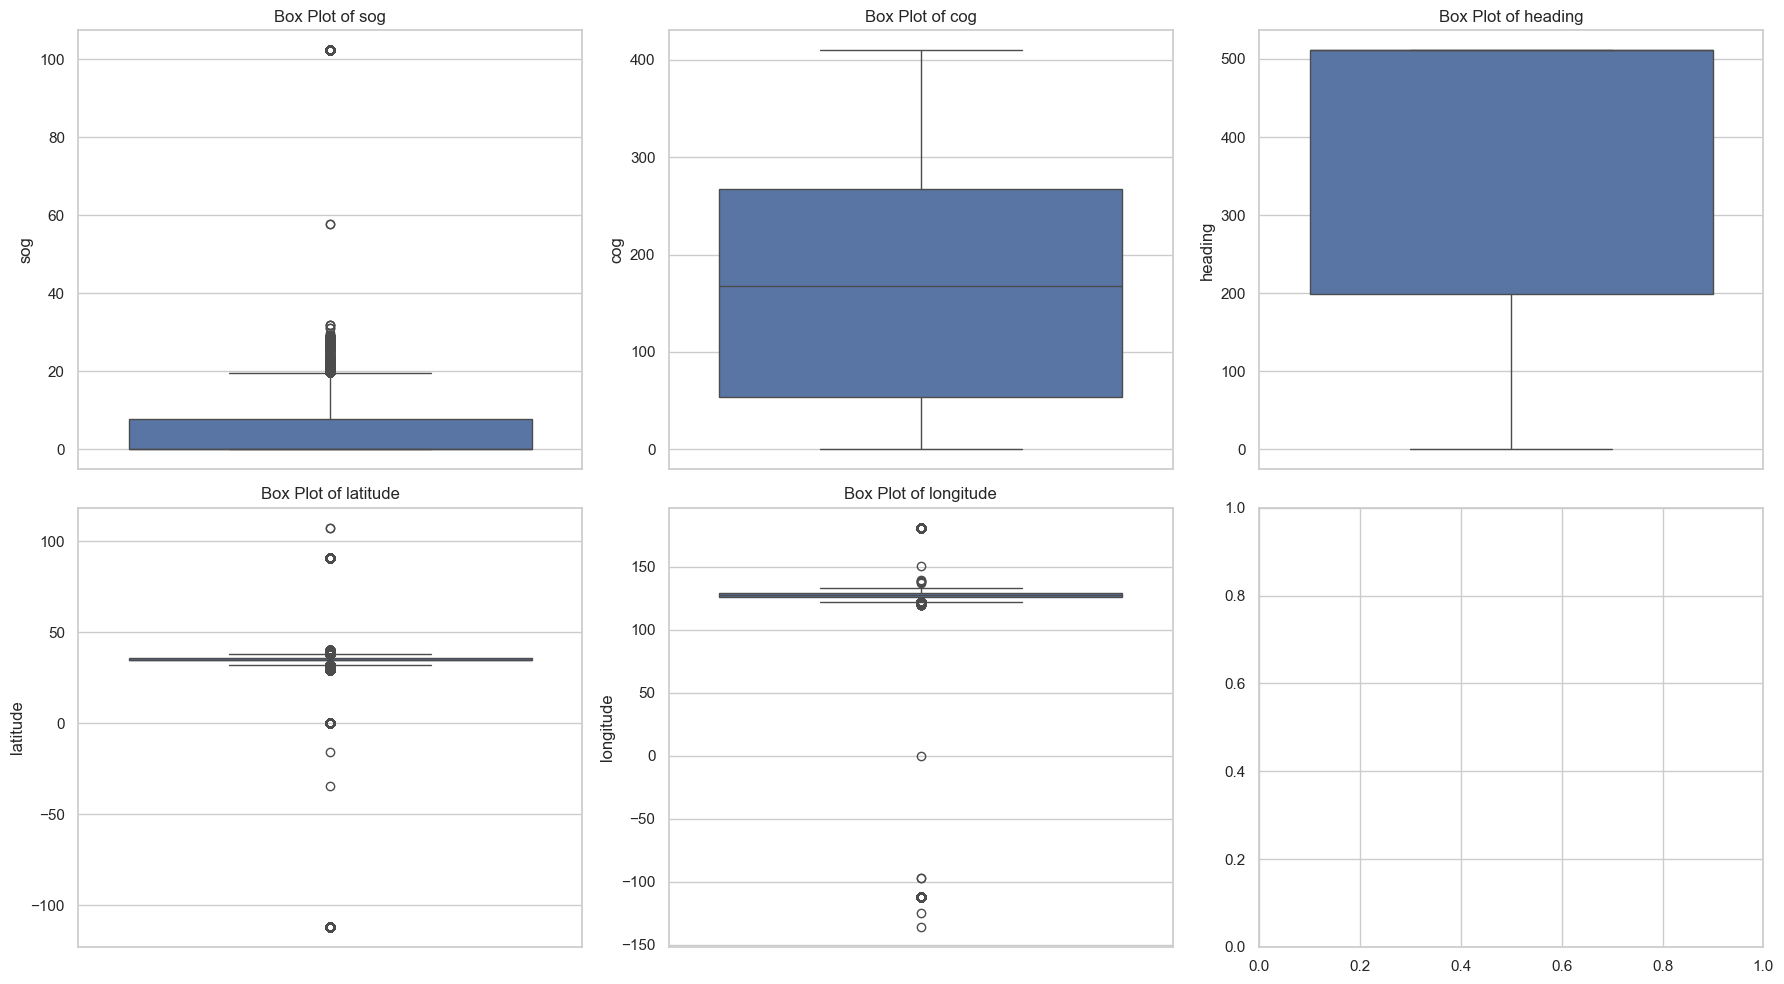

In [6]:
# ✅ 이상치 확인 (Box Plot)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
features = ["sog", "cog", "heading", "latitude", "longitude"]
for i, feature in enumerate(features):
    sns.boxplot(y=df[feature], ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f"Box Plot of {feature}")
plt.tight_layout()
plt.show()

In [7]:
# ✅ 이상치 제거 (IQR 방법)
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

for col in ["sog", "cog", "heading", "latitude", "longitude"]:
    df = remove_outliers(df, col)

print("📊 Outliers removed using IQR method ✅")

📊 Outliers removed using IQR method ✅


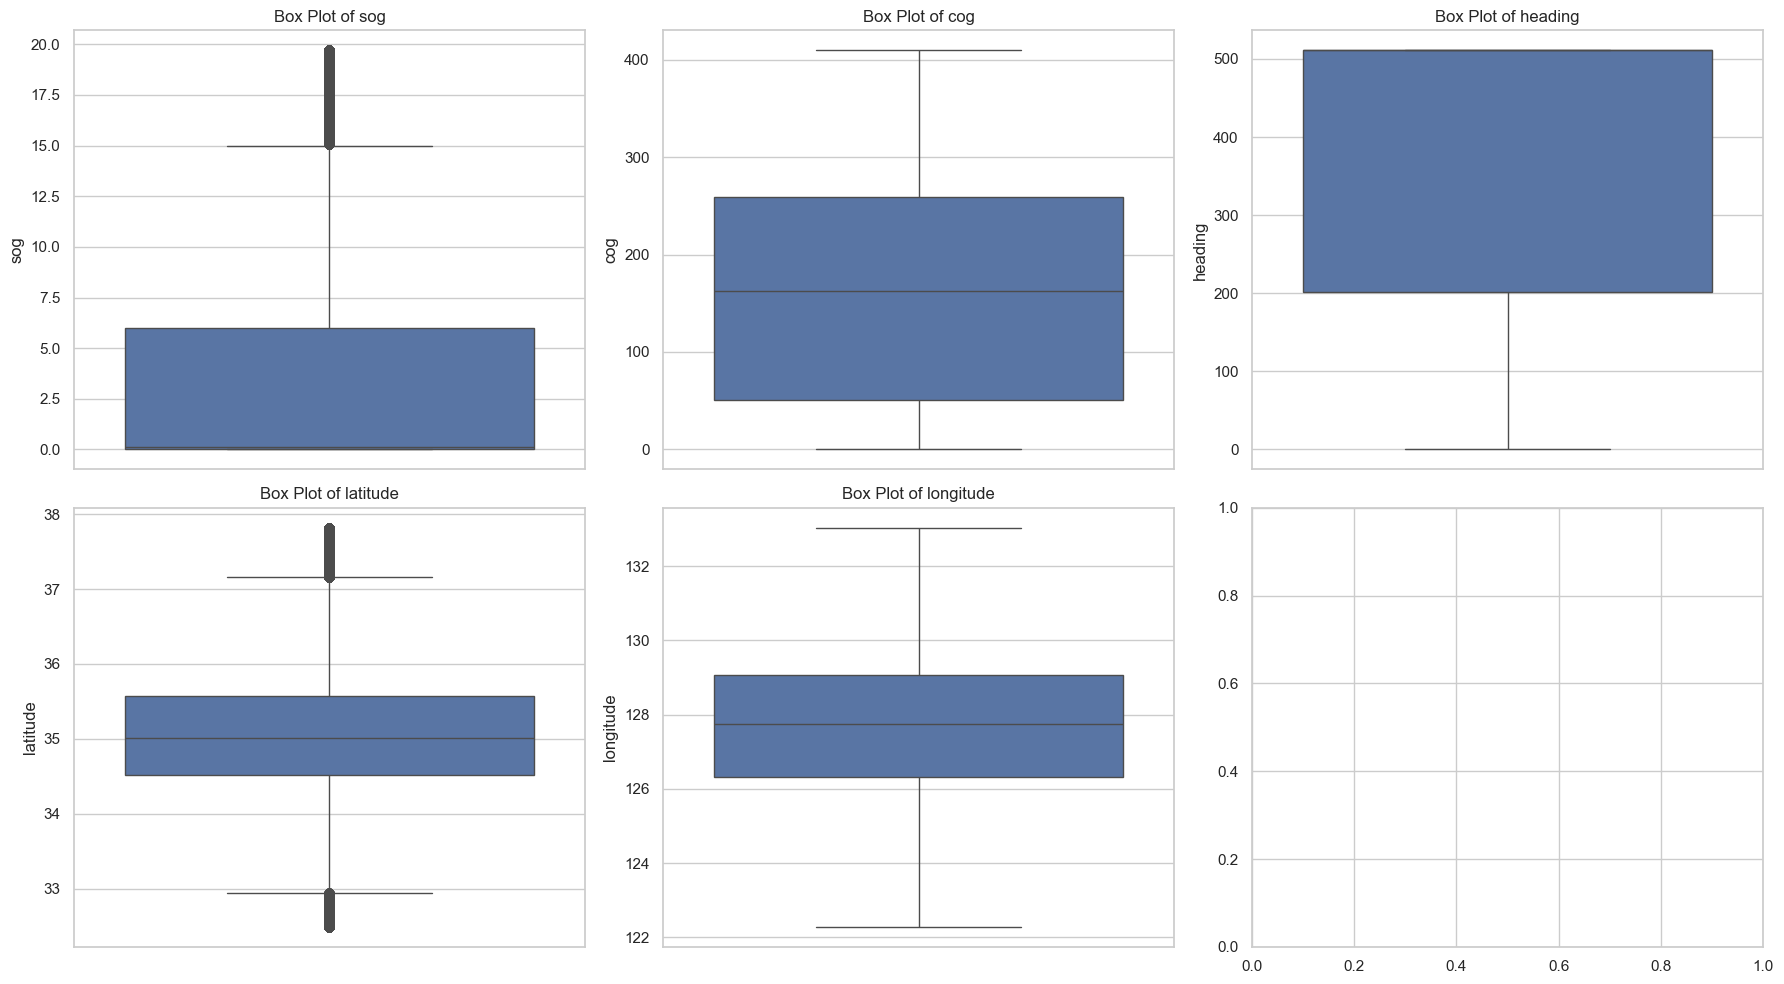

In [8]:
# ✅ 이상치 제거 확인 (Box Plot)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
features = ["sog", "cog", "heading", "latitude", "longitude"]
for i, feature in enumerate(features):
    sns.boxplot(y=df[feature], ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f"Box Plot of {feature}")
plt.tight_layout()
plt.show()